# Energetics and water budget: Western Pacific

In [ ]:
import sys
sys.path.append('/work/mh0731/m300876/package/')
import icons
import intake
import matplotlib.pyplot as plt
import healpy as hp
import xarray as xr
import numpy as np
import easygems.healpix as egh
import seaborn as sns

In [2]:
icons.prepare_cpu(memory='100GB')

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300876/levante-spawner-advanced//proxy/42421/status,
Dashboard: /user/m300876/levante-spawner-advanced//proxy/42421/status,Workers: 1
Total threads: 256,Total memory: 93.13 GiB
Status: running,Using processes: False
Comm: inproc://136.172.120.71/2443582/1,Workers: 1
Dashboard: /user/m300876/levante-spawner-advanced//proxy/42421/status,Total threads: 256
Started: Just now,Total memory: 93.13 GiB
Comm: inproc://136.172.120.71/2443582/4,Total threads: 256
Dashboard: /user/m300876/levante-spawner-advanced//proxy/41269/status,Memory: 93.13 GiB
Nanny: None,


### Predefined functions

In [53]:
### preprocess to modify data set
def preprocess(ds):
    """
    Adapts precipitation to the needs of this notebook.
    """
    ds = ds.assign(pr=(ds.pr * 86400).assign_attrs(units="mm d-1"))
    return ds

### Location mask
def tropics(ds):
    return np.abs(ds.lat) <= 30.1

def equator(ds):
    return np.abs(ds.lat) <= 5.1

def ocean(ds):
    return ds.ocean_fraction_surface == 1

def trop_wpacific(ds):
    return tropics(ds) & (ds.lon > 150) & (ds.lon < 170) 

def eq_wpacific(ds):
    return equator(ds) & (ds.lon > 150) & (ds.lon < 170) 

#### Calculate energy
def net_toa(ds):
    return (ds.rsdt - ds.rsut - ds.rlut)

def net_surface(ds):
    return (ds.rsus - ds.rsds + ds.rlus - ds.rlds)

def net_surface_sw(ds):
    return (ds.rsus - ds.rsds)

def net_surface_lw(ds):
    return (ds.rlus - ds.rlds)

def net_cooling(ds):
    return net_toa(ds) + net_surface_sw(ds) + net_surface_lw(ds)

def get_pe(ds):
    lv=22.6e5
    return (ds.pr*lv/ 86400 + ds.hflsd)

def net_fluxes(ds):
    return (-ds.hflsd - ds.hfssd)


## Calling data

In [4]:
%%time
### ICON
current_location = "online"
cat = cat = intake.open_catalog(
    "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]
exp_name = "icon_d3hp003"
experiment = cat[exp_name]
time_slice = slice("2020-02-01", "2021-01-31")
ds_icon = (
    experiment(zoom=8, time="P1D", chunks="auto")
    .to_dask()
    .pipe(egh.attach_coords)
    .pipe(preprocess)
    .sel(time=time_slice)
).mean('time')


CPU times: user 1.64 s, sys: 388 ms, total: 2.02 s
Wall time: 2.61 s


In [34]:
%%time
### NICAM
exp_name = "nicam_gl11"
experiment = cat[exp_name]
time_slice = slice("2020-04-01", "2021-03-31")
ds_nicam = (
    experiment(zoom=8, time="PT3H", chunks="auto")
    .to_dask()
    .pipe(preprocess)
    .sel(time=time_slice)
)

ds_nicam = ds_nicam.assign_coords(
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
).mean('time')

CPU times: user 405 ms, sys: 16.6 ms, total: 421 ms
Wall time: 2.9 s


In [8]:
%%time
### Unified Model
exp_name = "um_glm_n2560_RAL3p3"
experiment = cat[exp_name]
time_slice = slice("2020-03-01", "2021-03-01")
ds_um = (
    experiment(zoom=8, time="PT1H", chunks="auto")
    .to_dask()
    .pipe(preprocess)
    .sel(time=time_slice)
)

ds_um = ds_um.assign_coords(
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
).mean('time')

CPU times: user 515 ms, sys: 19.3 ms, total: 534 ms
Wall time: 1.61 s


### Energy and water budget: $Q_\mathrm{rad}$, $Q_\mathrm{surf}$, $P-E$, $\Gamma$

In [10]:
%%time
### ICON
qrad_icon = net_cooling(ds_icon.where(trop_wpacific(ds_icon))).compute()
qsurf_icon = net_fluxes(ds_icon.where(trop_wpacific(ds_icon))).compute()
pe_icon = get_pe(ds_icon.where(trop_wpacific(ds_icon))).compute()

CPU times: user 32 s, sys: 16 s, total: 48 s
Wall time: 26.5 s


In [56]:
%%time
### NICAM
qtoa_nicam = net_toa(ds_nicam.where(trop_wpacific(ds_nicam))).compute()
qnetsw_nicam = net_surface_sw(ds_nicam.where(trop_wpacific(ds_nicam))).compute()
qnetlw_nicam = net_surface_lw(ds_nicam.where(trop_wpacific(ds_nicam))).compute()
qrad_nicam = qtoa_nicam + qnetsw_nicam + qnetlw_nicam 

CPU times: user 12min 7s, sys: 3min 1s, total: 15min 9s
Wall time: 11min 24s


In [11]:
%%time
### NICAM
qsurf_nicam = net_fluxes(ds_nicam.where(trop_wpacific(ds_nicam))).compute()
pe_nicam = get_pe(ds_nicam.where(trop_wpacific(ds_nicam))).compute()

CPU times: user 16min 45s, sys: 8min 35s, total: 25min 21s
Wall time: 15min 25s


In [12]:
%%time
### Unified model
#qrad_um = net_cooling(ds_um.where(trop_wpacific(ds_um))).compute()
qsurf_um = net_fluxes(ds_um.where(trop_wpacific(ds_um))).compute()
pe_um = get_pe(ds_um.where(trop_wpacific(ds_um))).compute()

CPU times: user 17min 8s, sys: 2min 45s, total: 19min 54s
Wall time: 17min 18s


In [60]:
gamma_icon_calc = (qsurf_icon + qrad_icon)/ (pe_icon)
gamma_nicam_calc = (qsurf_nicam + qrad_nicam)/ (pe_nicam)

## Plotting

In [14]:
def custom_plot(ax,ylabel=None,xlabel=None,title=None,xticklabels=False):
    sns.despine(offset=10, ax=ax)
    ax.set_xticks([-20,-5,0,5,20])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if xticklabels == False:
        ax.set_xticklabels({})    

#### Zonal mean

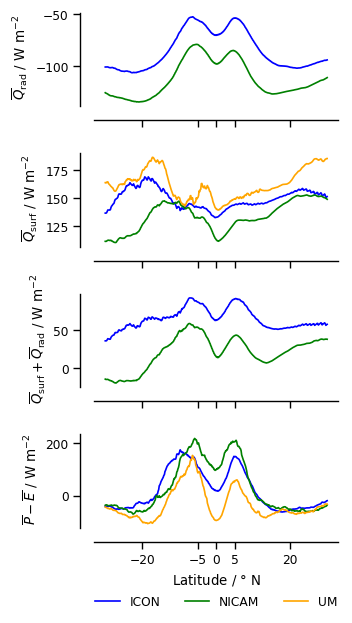

In [57]:
sns.set_context("paper")
fig = plt.figure(figsize=(8/2.54, 17/2.54), facecolor="white")

ax = fig.add_subplot(411)
qrad_icon.groupby("lat").mean().plot(color="b")
qrad_nicam.groupby("lat").mean().plot(color="green")
custom_plot(ax,ylabel=r" $\overline{Q}_\mathrm{rad}$ / W m$^{-2}$"
)

ax = fig.add_subplot(412)
qsurf_icon.groupby("lat").mean().plot(color="b")
qsurf_nicam.groupby("lat").mean().plot(color="green")
qsurf_um.groupby("lat").mean().plot(color="orange")
custom_plot(ax,ylabel=r" $\overline{Q}_\mathrm{surf}$ / W m$^{-2}$"
)

ax = fig.add_subplot(413)
(qsurf_icon+qrad_icon).groupby("lat").mean().plot(color="b")
(qsurf_nicam+qrad_nicam).groupby("lat").mean().plot(color="green")
custom_plot(ax,ylabel=r" $\overline{Q}_\mathrm{surf} + \overline{Q}_\mathrm{rad}$ / W m$^{-2}$"
)

ax = fig.add_subplot(414)
(pe_icon).groupby("lat").mean().plot(color="b",label='ICON')
(pe_nicam).groupby("lat").mean().plot(color="green",label='NICAM')
(pe_um).groupby("lat").mean().plot(color="orange",label='UM')
custom_plot(ax,ylabel=r" $\overline{P} - \overline{E}$ / W m$^{-2}$",
            xlabel=r"Latitude / $\degree$ N",xticklabels=True)

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.6),
    ncol=3,
    fancybox=False,
    shadow=False,
    frameon=False
)
plt.subplots_adjust(hspace=0.5)

#### $\Gamma$ : Histogram Western Pacific

In [61]:
hist_gammac_icon_wpacific= np.histogram((gamma_icon_calc).where( 
    eq_wpacific(gamma_icon_calc) & (pe_icon>0)),bins=np.arange(-2,2,0.1),
                                  density=True)

hist_gammac_nicam_wpacific = np.histogram((gamma_nicam_calc).where(
    eq_wpacific(gamma_nicam_calc) & (pe_nicam>0) ),bins=np.arange(-2,2,0.1),
                                  density=True)
                                                

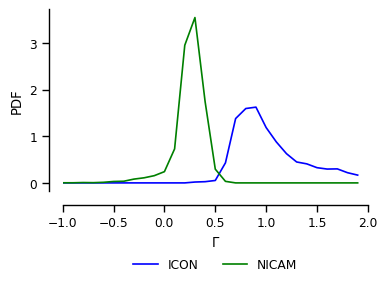

In [62]:
sns.set_context("paper")
fig = plt.figure(figsize=(10/2.54,6/2.54), facecolor="white")
ax = fig.add_subplot(1,1,1)
ax.plot(hist_gammac_icon_wpacific[1][1:],hist_gammac_icon_wpacific[0],'-b',label='ICON')
ax.plot(hist_gammac_nicam_wpacific[1][1:],hist_gammac_nicam_wpacific[0],'-g',label='NICAM')

plt.legend()
ax.set_xlim([-1,2])
sns.despine(offset=10)
ax.set_ylabel('PDF')
ax.set_xlabel(r'$\Gamma$')
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.5),
    ncol=2,
    fancybox=False,
    shadow=False,
    frameon=False
)